In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from PIL import Image
from tempfile import TemporaryDirectory
import glob
import copy

In [2]:
import os
cudnn.benchmark = True
plt.ion()   # interactive mode

# Data augmentation and normalization for training, validation, and test
def resize_with_padding(target_size):
    return transforms.Compose([
        transforms.Resize(target_size),                         # Resize smaller side
        transforms.Pad((0, 0, max(0, target_size[1] - target_size[0]), 
                             max(0, target_size[0] - target_size[1])), fill=0),
        transforms.CenterCrop(target_size),                    # Final crop just in case
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((400, 224)),                         # Maintain original
        transforms.Pad((0, 88)),                               # Pad width to get square: (400, 400)
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((400, 224)),
        #transforms.Pad((0, 88)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((400, 224)),
        transforms.Pad((0, 88)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'Dataset5AprV1_split'
# Create ImageFolder datasets for train, validation, and test
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val', 'test']
}

# Create DataLoaders; note that test loader uses shuffle=False
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=16, shuffle=True, num_workers=6),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=16, shuffle=True, num_workers=6),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=16, shuffle=False, num_workers=6)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [3]:
# Use CUDA if available; otherwise fallback to CPU.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


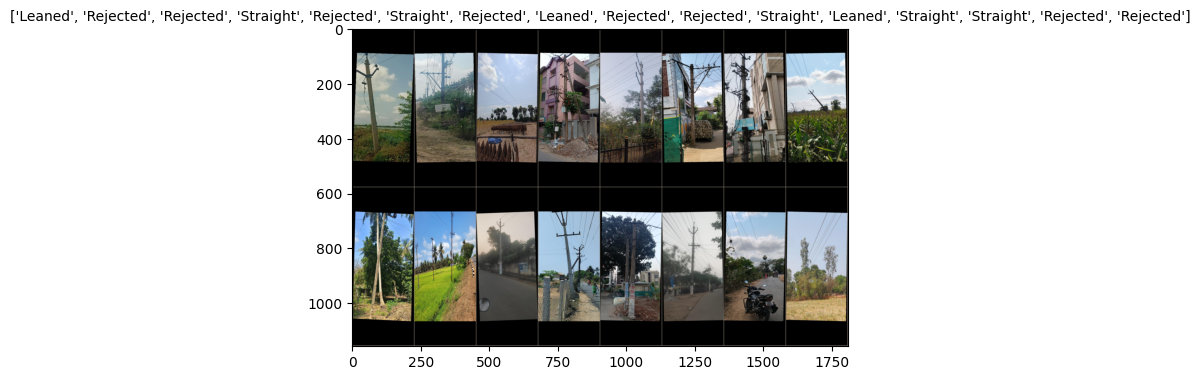

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))  # CHW -> HWC
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title, fontsize=10)

    plt.pause(0.001)

# Display a batch of training data (optional)
inputs, classes_batch = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes_batch])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=70, save_dir='saved_models'):
    # Create the save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    best_model_params_path = os.path.join(save_dir, 'best_model_params.pt')
    best_acc = 0.0
    since = time.time()
    
    # Save initial model (optional)
    torch.save(model.state_dict(), best_model_params_path)
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Adjust scheduler after validation phase
            if phase == 'val':
                scheduler.step(epoch_loss)

            # Save the best model (based on validation accuracy)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
    return model


In [6]:
def visualize_dataset(model, phase='val', num_images=6):
    model.eval()
    images_so_far = 0

    # Set rows and cols based on num_images
    cols = 3
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(cols * 6, rows * 6))  # Bigger canvas (try 6 or even 7)


    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(rows, cols, images_so_far)
                ax.axis('off')

                pred_label = class_names[preds[j]]
                true_label = class_names[labels[j]]

                ax.set_title(f'Pred: {pred_label}\nTrue: {true_label}',
                             color='red' if pred_label != true_label else 'green')

                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    plt.tight_layout()
                    plt.show()
                    return

    plt.tight_layout()
    plt.show()


Epoch 0/69
----------
train Loss: 0.6862 Acc: 0.7670
val Loss: 1.1334 Acc: 0.6415

Epoch 1/69
----------
train Loss: 0.4076 Acc: 0.9490
val Loss: 1.1201 Acc: 0.5849

Epoch 2/69
----------
train Loss: 0.3624 Acc: 0.9745
val Loss: 1.0250 Acc: 0.6509

Epoch 3/69
----------
train Loss: 0.3601 Acc: 0.9730
val Loss: 1.0213 Acc: 0.6792

Epoch 4/69
----------
train Loss: 0.3281 Acc: 0.9865
val Loss: 0.9322 Acc: 0.6792

Epoch 5/69
----------
train Loss: 0.3167 Acc: 0.9932
val Loss: 0.9601 Acc: 0.6604

Epoch 6/69
----------
train Loss: 0.3122 Acc: 0.9936
val Loss: 0.9504 Acc: 0.6792

Epoch 7/69
----------
train Loss: 0.3176 Acc: 0.9899
val Loss: 1.2823 Acc: 0.5660

Epoch 8/69
----------
train Loss: 0.3584 Acc: 0.9734
val Loss: 1.2512 Acc: 0.5849

Epoch 9/69
----------
train Loss: 0.3291 Acc: 0.9850
val Loss: 1.0650 Acc: 0.6415

Epoch 10/69
----------
train Loss: 0.3092 Acc: 0.9951
val Loss: 1.0170 Acc: 0.6415

Epoch 11/69
----------
train Loss: 0.3028 Acc: 0.9955
val Loss: 0.9784 Acc: 0.6698

Ep

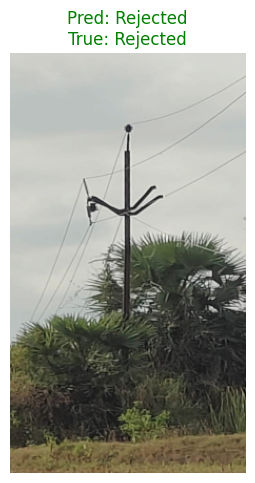

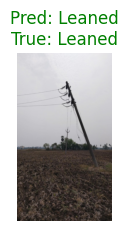

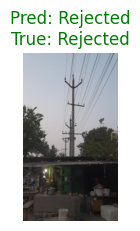

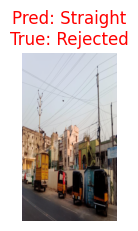

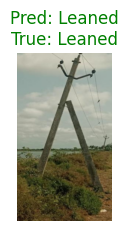

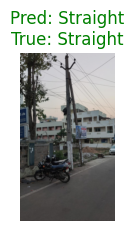

<Figure size 640x480 with 0 Axes>

In [7]:
from torchvision.models import mobilenet_v3_small

# 1. Load and modify MobileNetV3
model_ft = mobilenet_v3_small(weights='DEFAULT')  # or None if training from scratch
num_ftrs = model_ft.classifier[3].in_features
model_ft.classifier[3] = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

# 2. Define loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# 3. Optimizer
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.00095)

# 4. Scheduler (if using)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', patience=5, factor=0.5)

# 5. Train
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=70)

# 6. Visualize
visualize_dataset(model_ft, phase='val')


In [26]:
def visualize_test_images_from_folders(model, class_names, max_images=8):
    import math
    model.eval()

    image_paths = glob.glob('Dataset5AprV1_split/test/*/*.*')  # Accept any image format
    if len(image_paths) == 0:
        print("No test images found.")
        return

    shown = 0
    images_per_row = 3
    rows = math.ceil(max_images / images_per_row)
    plt.figure(figsize=(images_per_row * 6, rows * 6))  # Bigger canvas (try 6 or even 7)


    for img_path in image_paths:
        if shown >= max_images:
            break

        true_label = os.path.basename(os.path.dirname(img_path))
        img = Image.open(img_path).convert('RGB')
        input_tensor = data_transforms['val'](img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            _, pred = torch.max(output, 1)
            predicted_label = class_names[pred.item()]

        ax = plt.subplot(rows, images_per_row, shown + 1)
        ax.axis('off')
        ax.set_title(f'Pred: {predicted_label}\nTrue: {true_label}',
                     color='red' if predicted_label != true_label else 'green')
        imshow(input_tensor.cpu().data[0])
        shown += 1

    plt.tight_layout()
    plt.show()


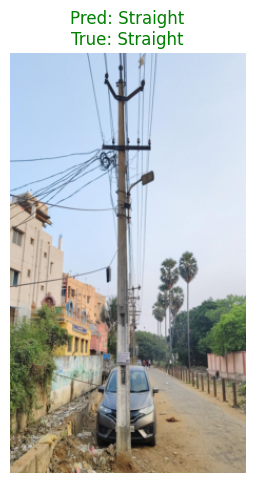

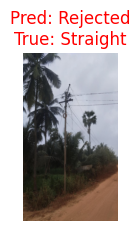

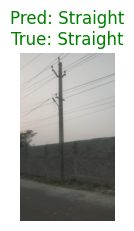

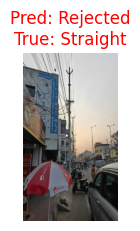

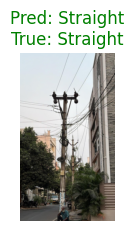

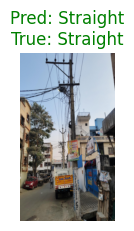

<Figure size 640x480 with 0 Axes>

In [28]:
visualize_test_images_from_folders(model_ft, class_names, max_images=6)

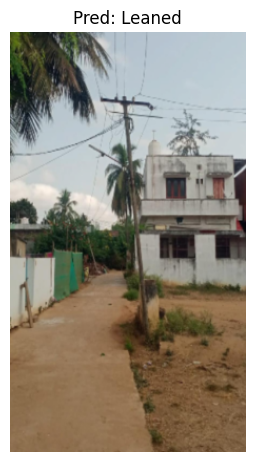

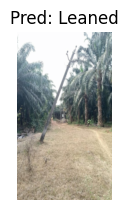

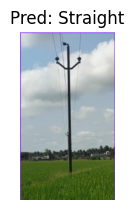

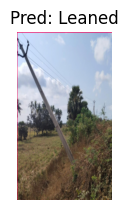

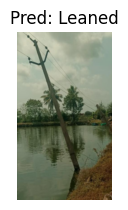

<Figure size 640x480 with 0 Axes>

In [30]:
# Load the best model from the saved directory
from torchvision.models import mobilenet_v3_small

# Reinitialize the model architecture
model_ft = mobilenet_v3_small(weights='DEFAULT')  # Use default pretrained weights
num_ftrs = model_ft.classifier[3].in_features
model_ft.classifier[3] = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

# Load the best saved model weights
model_ft.load_state_dict(torch.load(os.path.join('saved_models', 'best_model_params.pt')))
model_ft.eval()

def visualize_custom_data(model, custom_data_dir, max_images=8):
    import math
    # Get all images from the custom folder
    image_paths = glob.glob(os.path.join(custom_data_dir, '*.*'))
    if len(image_paths) == 0:
        print("No custom images found in", custom_data_dir)
        return

    images_per_row = 3
    rows = math.ceil(max_images / images_per_row)
    plt.figure(figsize=(images_per_row * 6, rows * 6))
    
    shown = 0
    for img_path in image_paths:
        if shown >= max_images:
            break

        # Load the image
        img = Image.open(img_path).convert('RGB')
        # Use the same transform as for validation
        input_tensor = data_transforms['val'](img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            _, pred = torch.max(output, 1)
            predicted_label = class_names[pred.item()]

        ax = plt.subplot(rows, images_per_row, shown + 1)
        ax.axis('off')
        ax.set_title(f'Pred: {predicted_label}')
        imshow(input_tensor.cpu().data[0])
        shown += 1

    plt.tight_layout()
    plt.show()

# Visualize custom images (adjust the folder name and max_images as needed)
visualize_custom_data(model_ft, custom_data_dir='custom_data', max_images=5)


In [11]:
import glob

image_paths = glob.glob('Dataset5AprV1_split/test/*/*.jpg')
print(f"Found {len(image_paths)} test images.")
print("\nSample paths:")
print("\n".join(image_paths[:5]))


Found 71 test images.

Sample paths:
Dataset5AprV1_split/test/Straight/IMG-20250317-WA1553_jpg.rf.758ffbf1a3177f27aba24ba7d1dbf13d.jpg
Dataset5AprV1_split/test/Straight/IMG-20250318-WA0002_jpg.rf.6bfa8fd3805fe7cf124868d96c3f9065.jpg
Dataset5AprV1_split/test/Straight/IMG-20250317-WA1353_jpg.rf.27608c46d53343cf3871b3e5a0f55ef5.jpg
Dataset5AprV1_split/test/Straight/IMG-20250317-WA0697_jpg.rf.cf38436455fc2f889ffb589ff63892d7.jpg
Dataset5AprV1_split/test/Straight/IMG-20250317-WA1782_jpg.rf.5964b200dd6e65497953c42574261b33.jpg
